In [3]:
import os
import sys
import math
import scipy as scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import hashlib
from IPython.display import display
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb

tqdm.pandas()


EPOCHS = 20
SAMPLE_LEN = 100

IMAGE_PATH = "C:/Users/ADMIN/Downloads/Compressed/ZEFT/images"
TEST_PATH = "C:/Users/ADMIN/Downloads/Compressed/ZEFT/test.csv"
TRAIN_PATH = "C:/Users/ADMIN/Downloads/Compressed/ZEFT/train.csv"
SUB_PATH = "C:/Users/ADMIN/Downloads/Compressed/ZEFT/sample_submission.csv"

sub = pd.read_csv(SUB_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)
train_data.head()
test_data.head()
import plotly.express as px
import numpy as np
def load_image(image_id):
    file_path = image_id + ".jpg"
    image = cv2.imread(IMAGE_PATH + file_path)
    #return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data["image_id"][:SAMPLE_LEN].progress_apply(load_image)
# Initializing some plotting variables
pd.set_option('display.max_columns', 30)
label_font_dict = {'family':'sans-serif','size':13.5,'color':'brown','style':'italic'}
title_font_dict = {'family':'sans-serif','size':17.5,'color':'Blue','style':'italic'}
# plant pathology 2020
pp_2020_train_csv_file = "train.csv"
pp_2020_test_csv_file = "test.csv"

## train images csv file name
train_images_info_csv = "C:/Users/ADMIN/Downloads/Compressed/ZEFT/train.csv"
print("### Train images csv file is --> {} \n".format(train_images_info_csv))

## train images details
train_images_info_df = pd.read_csv(train_images_info_csv)
train_images_info_df
# checking data types of the columns
train_images_info_df.dtypes


100%|██████████| 100/100 [00:00<00:00, 24988.41it/s]

### Train images csv file is --> C:/Users/ADMIN/Downloads/Compressed/ZEFT/train.csv 



image_id             object
healthy               int64
multiple_diseases     int64
rust                  int64
scab                  int64
dtype: object

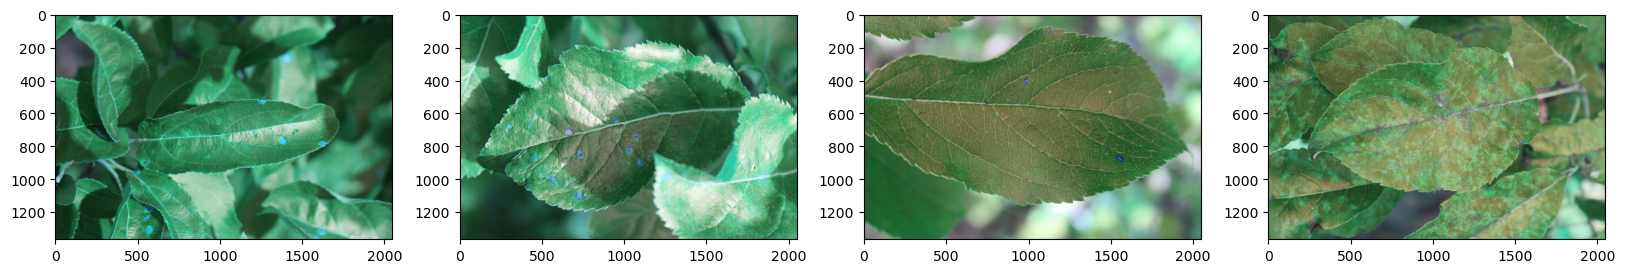

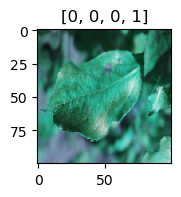

In [4]:
dataset_folder = os.path.join("C:/Users/ADMIN/Downloads/Compressed/ZEFT")
import pathlib
from keras.metrics import Precision, Recall
import tensorflow as tf
imagesDataset = pathlib.Path(os.path.join(dataset_folder, "images"))
listImages = list(imagesDataset.glob("*.*"))
plt.figure(figsize = (20, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    img = cv2.imread(str(listImages[i]))
    plt.imshow(img)
plt.show()
datasetObject = pd.read_csv(os.path.join(dataset_folder, "train.csv"))
datasetObject.head()
images_id_csv = datasetObject['image_id']
healthy_csv = datasetObject['healthy']
multiple_diseases_csv = datasetObject['multiple_diseases']
rust_csv = datasetObject['rust']
scab_csv = datasetObject['scab']
images = []
labels = []
for index, values in enumerate(images_id_csv):
    img = cv2.imread(os.path.join(dataset_folder, "images", "{}.jpg".format(values)))
    img = cv2.resize(img, (100, 100))
    img = img/255
    labels.append([healthy_csv[index], multiple_diseases_csv[index], rust_csv[index],
                 scab_csv[index]])
    images.append(img)
plt.figure(figsize = (12, 8))
for i in range(1):
  plt.subplot(4, 4, i + 1)
  plt.imshow(images[i])
  plt.title(labels[i])
plt.show()
img_data_g = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=0.35,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        shear_range=0.2,
        width_shift_range=0.15,
        height_shift_range=0.15,
        rescale=None)
images_after_aug = []
labels_after_aug = []
for index, image in enumerate(images):
  for i in range(1):
      img = img_data_g.flow(np.reshape(image, (1, 100, 100, 3))).next()
      images_after_aug.append(np.reshape(img, (100, 100, 3)))
      labels_after_aug.append(labels[index])
labels = np.asarray(labels_after_aug)
images = np.asarray(images_after_aug)

In [5]:
d = tf.keras.applications.DenseNet121(include_top=False,
                   input_shape=(100,100,3),
                   pooling=None,
                   weights='imagenet')
for i in d.layers:
  i.trainable = True
output_avg = tf.keras.layers.GlobalAveragePooling2D()(d.output)
output_max = tf.keras.layers.GlobalMaxPooling2D()(d.output)
m = tf.keras.layers.minimum([output_avg, output_max])
m = tf.keras.layers.Dropout(0.5)(m)
m = tf.keras.layers.Dense(128, activation = "sigmoid")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(256, activation = "relu")(m)
m = tf.keras.layers.Dropout(0.3)(m)
m = tf.keras.layers.Dense(4, activation= "softmax")(m)
m = tf.keras.models.Model(inputs = d.input, outputs = m)
m.compile(optimizer = tf.keras.optimizers.Adam(0.001), 
          loss = "categorical_crossentropy", 
          metrics =["accuracy", 
                     Precision(name='precision'), 
                     Recall(name='recall')])
m.summary()
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.15, random_state = 42)


print("x train: ",x_train.shape)
print("x test: ",x_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)
history = m.fit(x_train, y_train, epochs = 12, batch_size = 32,
                callbacks = [
                    tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, mode = 'min',
                                                  patience= 1),
                    tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, mode = 'min', restore_best_weights = True)
                ])





import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.metrics import Precision, Recall
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import xgboost as xgb
import seaborn as sns
import cv2
import pathlib
import os
new_model = tf.keras.models.Model(
    m.input, m.get_layer('minimum').output
)
y_pred = m.predict(x_test)
y_pred = np.argmax(y_pred, axis = 1)
y_test = np.argmax(y_test, axis = 1)
features_x_train = new_model.predict(x_train)
features_x_test = new_model.predict(x_test)
features_x_train.shape
scaler = StandardScaler()
scaler.fit(features_x_train)
x_tr = scaler.transform(features_x_train)
x_te = scaler.transform(features_x_test)
from sklearn.svm import SVC
clf = SVC(decision_function_shape='ovo')
clf.fit(x_tr,np.argmax(y_train, axis = 1))
y_pred = clf.predict(x_te)

svm_acc = accuracy_score(y_test,y_pred)
print(svm_acc)



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 50, 50, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1/conv[0][0]']         